In [1]:
import numpyro
import numpy as np 
from jax import random

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive


# Bayesian Heirarchical Model Example (HBM)

Here we will look at an example of finding the ages of people in a room.  This is a silly example but will show the value of the hierarchical method. 

We will start with a model that treats each individual in the room as unconnected and uses a simple predetermined age likelihood for the estimate of the age on a per-person basis. 

The prior will be ... 

$$ages \sim \log \mathcal{N}(\log 35, 0.3)$$

The likelihood for each person will be, 

$$age_i \sim \mathcal{N}(ages, 5.0, {\rm obs}= {\rm obs}_i)$$

We can make some data for this examplke and then code up this simple model in numpyro. 

In [10]:


n_people = 30
# Make the true ages and store them
ages_true = np.exp(np.random.randn(n_people) * 0.01 + 4.0)
# Add uncertainty of about 10% to the observed ages
ages_observed = ages_true + np.random.randn(n_people) * 5.0 


In [11]:
def model(observed_ages=[]):
    with numpyro.plate('plate_i', n_people):
        age = numpyro.sample('age', dist.LogNormal(np.log(35), 0.3))
        
    if len(observed_ages) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs', dist.Normal(age, 5.0), obs=observed_ages)

## Prior check

In [12]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1556.85it/s, 7 steps of size 5.36e-01. acc. prob=0.89] 


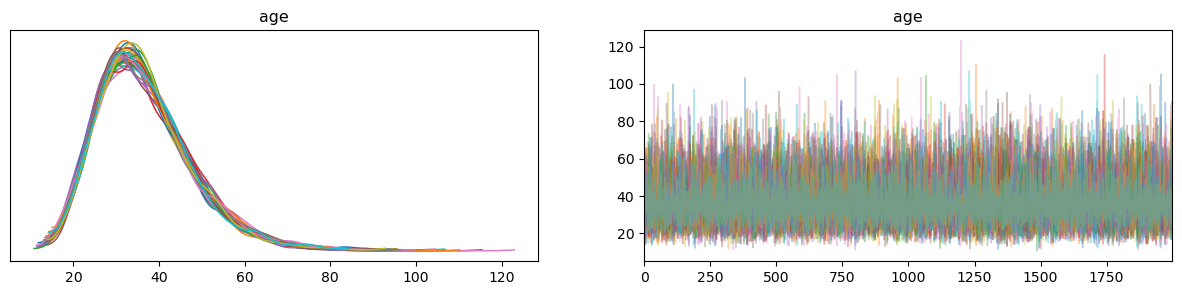

In [13]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 3));

## The actual run ... 

In [14]:
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, ages_observed)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1923.80it/s, 7 steps of size 5.63e-01. acc. prob=0.86]


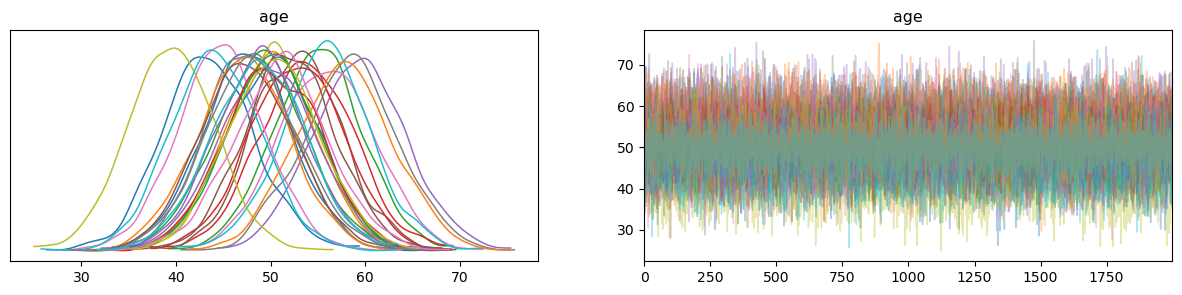

In [15]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 3));

You can see that we have noisy estimates of age for all 30 people.  Here comes the clever bit - we add more3 information.  We are told that the room of 30 people is actually a University reunion get together.  Hence we now know that all the prople in the room should be of a similar age. But we do not know that that age should be.  So we make a new model with a hyperprior: 

$${ \rm mean \, age} \sim \log \mathcal{N}(\log 35, 0.3)$$

A prior: 

$$ages \sim \mathcal{N}({ \rm mean \, age}, 1.0)$$

and likelihood for each person:

$$age_i \sim \mathcal{N}(ages_i, 5.0, {\rm obs}= {\rm obs}_i)$$

In [16]:
def HBmodel(observed_ages=[]):
    mean_age = numpyro.sample('mean_age', dist.LogNormal(np.log(35), 0.3))
    
    with numpyro.plate('plate_i', n_people):
        age = numpyro.sample('age', dist.Normal(mean_age, 1.0))
        
    if len(observed_ages) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs', dist.Normal(age, 5.0), obs=observed_ages)

In [17]:
nuts_kernel = NUTS(HBmodel)

hbm_mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=4000)
rng_key = random.PRNGKey(0)
hbm_mcmc.run(rng_key, ages_observed)

posterior_samples = hbm_mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [00:05<00:00, 1542.38it/s, 15 steps of size 1.71e-01. acc. prob=0.94]


In [18]:
hbm_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    age[0]     52.75      1.30     52.73     50.65     54.92    403.75      1.00
    age[1]     52.90      1.29     52.89     50.88     55.07    398.58      1.00
    age[2]     53.07      1.31     53.08     50.81     55.12    432.33      1.00
    age[3]     53.03      1.32     53.05     50.91     55.23    431.55      1.00
    age[4]     53.25      1.29     53.25     51.16     55.30    384.41      1.00
    age[5]     52.99      1.32     53.00     50.71     55.06    401.31      1.00
    age[6]     53.12      1.31     53.12     51.00     55.27    422.84      1.00
    age[7]     52.79      1.30     52.78     50.84     55.09    392.94      1.00
    age[8]     52.89      1.31     52.90     50.74     54.94    385.50      1.00
    age[9]     53.11      1.30     53.11     51.05     55.33    394.40      1.00
   age[10]     52.61      1.30     52.62     50.56     54.80    413.92      1.00
   age[11]     52.77      1

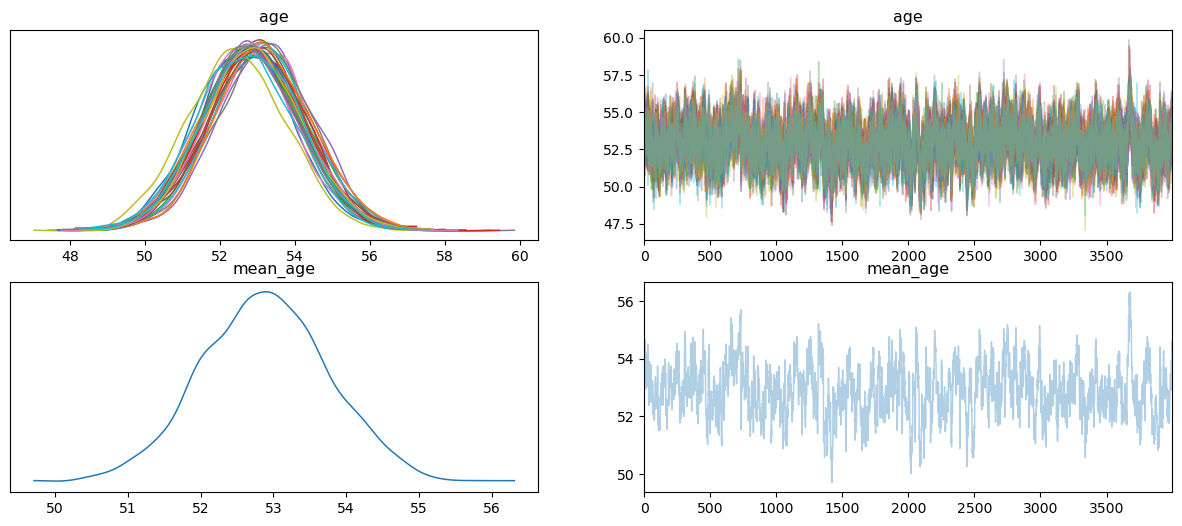

In [19]:
hbm_data = az.from_numpyro(hbm_mcmc)
az.plot_trace(hbm_data, compact=True, figsize=(15, 6));

## An even better HBM model (computationally)

In [20]:
def HBmodel2(observed_ages=[]):
    mean_age = numpyro.sample('mean_age', dist.LogNormal(np.log(35), 0.3))
    
    with numpyro.plate('plate_i', n_people):
        age_ = numpyro.sample('age_', dist.Normal(0, 1.0))
        age = numpyro.deterministic('age', mean_age + age_)
        
    if len(observed_ages) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs', dist.Normal(age, 5.0), obs=observed_ages)

In [21]:
nuts_kernel = NUTS(HBmodel2)

hbm_mcmc2 = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
hbm_mcmc2.run(rng_key, ages_observed)

posterior_samples = hbm_mcmc2.get_samples()

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1272.82it/s, 7 steps of size 6.13e-01. acc. prob=0.85]


In [22]:
hbm_mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   age_[0]     -0.13      0.99     -0.12     -1.80      1.45   5767.02      1.00
   age_[1]     -0.02      0.97     -0.01     -1.55      1.60   5043.15      1.00
   age_[2]      0.20      1.01      0.21     -1.42      1.81   5584.54      1.00
   age_[3]      0.13      0.99      0.12     -1.50      1.75   5414.24      1.00
   age_[4]      0.37      0.95      0.36     -1.22      1.87   5225.17      1.00
   age_[5]      0.09      0.97      0.09     -1.56      1.65   6212.45      1.00
   age_[6]      0.25      0.95      0.25     -1.40      1.66   4642.30      1.00
   age_[7]     -0.10      0.99     -0.10     -1.77      1.45   5260.55      1.00
   age_[8]     -0.00      0.96      0.00     -1.62      1.49   4612.35      1.00
   age_[9]      0.22      0.99      0.23     -1.42      1.80   4989.27      1.00
  age_[10]     -0.30      1.00     -0.30     -1.91      1.36   4779.51      1.00
  age_[11]     -0.14      0

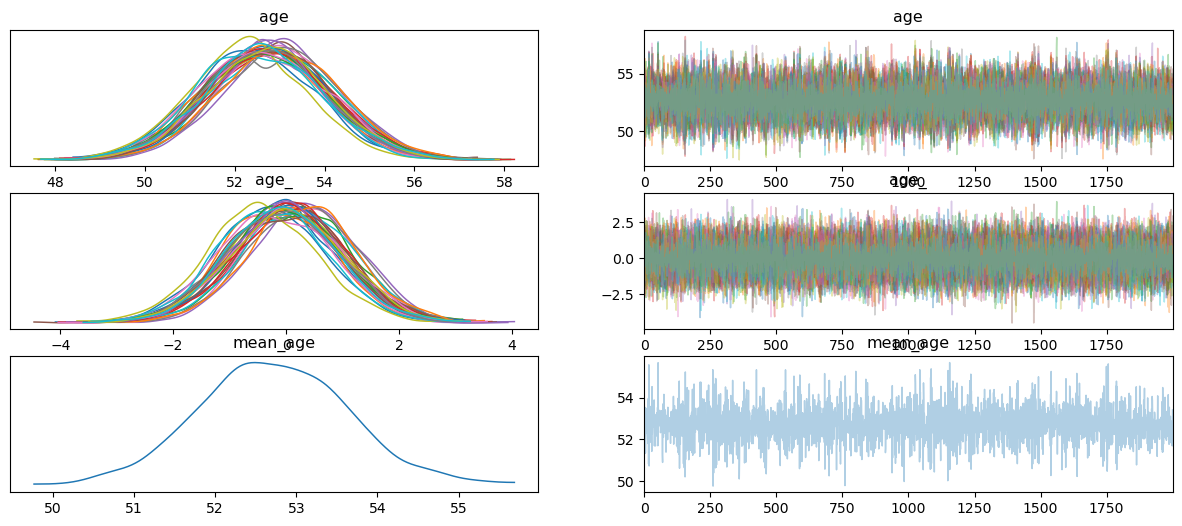

In [23]:
hbm_data2 = az.from_numpyro(hbm_mcmc2)
az.plot_trace(hbm_data2, compact=True, figsize=(15, 6));

Notice how the number of effective samples (n_eff) is much higher for the second HBM model even though we ran it for less iterations. 